<a href="https://colab.research.google.com/github/lorihe/Springboard-Capstone3---Transfer_Learning/blob/colab/01_Data_Wrangling_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras import callbacks, optimizers
from tensorflow.keras.layers import Dense, Conv2D, GlobalAvgPool2D, Input
import cv2
import imghdr
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from google.colab import drive
import shutil

### Data Review

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/Game_Classification

/content/drive/MyDrive/Game_Classification


In [ ]:
print(os.listdir('raw_data'))

['train', 'test']


In [ ]:
print(os.listdir('raw_data/train'))
print(os.listdir('raw_data/test'))

['soccer', 'rugby']
['rugby', 'soccer']


In [ ]:
# Check the label balance in the dataset
print(len(os.listdir('raw_data/train/rugby')))
print(len(os.listdir('raw_data/train/soccer')))
print(len(os.listdir('raw_data/test/rugby')))
print(len(os.listdir('raw_data/test/soccer')))

1224
1224
305
305


In [ ]:
# Check the file names
print(os.listdir('raw_data/train/rugby')[:5])
print(os.listdir('raw_data/train/rugby')[-5:])

['rugby.1,095.jpg', 'rugby.1,097.jpg', 'rugby.1,099.jpg', 'rugby.1,094.jpg', 'rugby.1,096.jpg']
['rugby.990.jpg', 'rugby.993.jpg', 'rugby.997.jpg', 'rugby.996.jpg', 'rugby.994.jpg']


In [ ]:
# Check the file names
print(os.listdir('raw_data/train/soccer')[:5])
print(os.listdir('raw_data/train/soccer')[-5:])

['rugby.1,020.jpg', 'rugby.1,021.jpg', 'rugby.1,019.jpg', 'rugby.1,016.jpg', 'rugby.1,018.jpg']
['rugby.576.jpg', 'rugby.982.jpg', 'rugby.997.jpg', 'rugby.1,088.jpg', 'rugby.1,136.jpg']


Note: Images in the train soccer folder are wrongly labeled

In [ ]:
print(os.listdir('raw_data/test/rugby')[:5])
print(os.listdir('raw_data/test/rugby')[-5:])

['rugby.1,307.jpg', 'rugby.1,305.jpg', 'rugby.1,306.jpg', 'rugby.1,304.jpg', 'rugby.1,303.jpg']
['rugby.1,233.jpg', 'rugby.1,238.jpg', 'rugby.1,265.jpg', 'rugby.1,270.jpg', 'rugby.1,299.jpg']


In [ ]:
print(os.listdir('raw_data/test/soccer')[:5])
print(os.listdir('raw_data/test/soccer')[-5:])

['rugby.1,441.jpg', 'rugby.1,230.jpg', 'rugby.1,229.jpg', 'rugby.1,228.jpg', 'rugby.1,225.jpg']
['rugby.1,526.jpg', 'rugby.1,240.jpg', 'rugby.1,285.jpg', 'rugby.1,388.jpg', 'rugby.1,416.jpg']


Note: Images in the train soccer folder are wrongly labeled

In [ ]:
image_classes = ['rugby', 'soccer']

In [ ]:
image_exts =['JPEG', 'JPG', 'BMP', 'PNG']

In [ ]:
#Check the file formats
NoneType = 0
for folder in os.listdir('raw_data'):
  for image_class in image_classes:
    for image in os.listdir(os.path.join('raw_data', folder, image_class)):
      image_path = os.path.join('raw_data', folder, image_class, image)
      try:
        with Image.open(image_path) as img:
          assert type(img) != None
          format = img.format
        if format not in image_exts:
          print('Format of {} is {}'.format(image_path, format))
      except Exception as e:
          print('Issue with image {}'.format(image_path))

Format of raw_data/train/soccer/rugby.26.jpg is MPO
Format of raw_data/test/soccer/rugby.1,388.jpg is MPO


In [ ]:
#Check if MPO file can be processed
mpo_img = cv2.imread('raw_data/train/soccer/rugby.26.jpg')
mpo_img[:2]

array([[[ 62,  51,  53],
        [ 67,  56,  58],
        [ 67,  56,  58],
        ...,
        [108, 112, 140],
        [110, 114, 142],
        [111, 115, 143]],

       [[ 68,  57,  59],
        [ 67,  56,  58],
        [ 63,  52,  54],
        ...,
        [105, 110, 135],
        [107, 112, 137],
        [109, 114, 139]]], dtype=uint8)

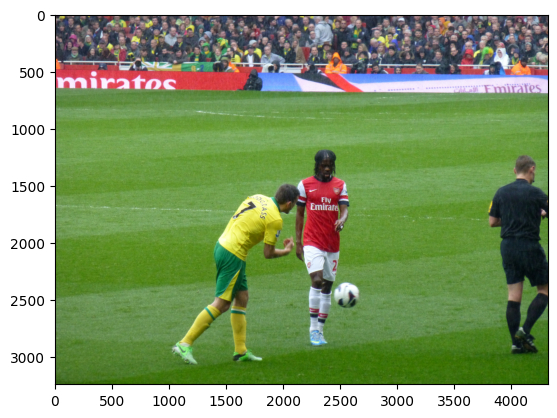

In [ ]:
plt.imshow(cv2.cvtColor(mpo_img, cv2.COLOR_BGR2RGB))

In [ ]:
mpo_img = cv2.imread('raw_data/test/soccer/rugby.1,388.jpg')
mpo_img[:2]

array([[[237, 253, 252],
        [236, 252, 251],
        [231, 246, 248],
        ...,
        [ 21,  45,  99],
        [ 18,  43,  93],
        [ 16,  41,  91]],

       [[235, 251, 250],
        [239, 255, 254],
        [233, 251, 252],
        ...,
        [ 18,  42,  94],
        [ 13,  36,  86],
        [  8,  31,  81]]], dtype=uint8)

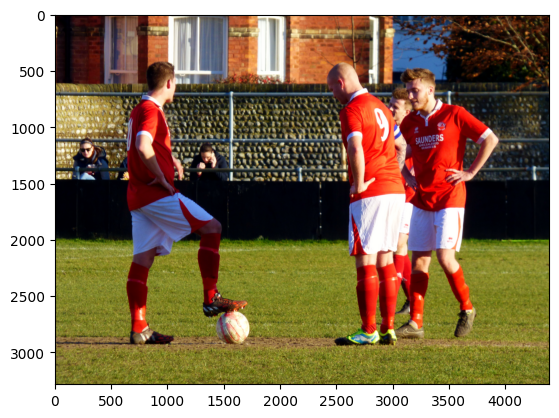

In [ ]:
plt.imshow(cv2.cvtColor(mpo_img, cv2.COLOR_BGR2RGB))

Note: Both MPO images can be processed.

**Note**: By browsing images in the folder, it was noticed that a few basketball/American football pictures were placed in the soccer folders. Those pictures are manually replaced with correct soccer pictures in this project.

It was also noticed that  multiple American football pictures were placed in the rugby folders. Those pictures are not corrected at the moment.

### Fix the wrongly labled file name

In [ ]:
#Create a copy of raw_data folder
shutil.copytree('raw_data', 'clean_data')

'clean_data'

In [ ]:
soccer_train_files = [filename for filename in os.listdir('clean_data/train/soccer') if filename.lower().endswith(('.jpg', '.png', '.jpeg'))]
print(len(soccer_train_files))
soccer_train_files.sort()

1224


In [ ]:
#Replace file names for taining data
for i, old_filename in enumerate(soccer_train_files, start=1):
    extension = os.path.splitext(old_filename)[1]
    new_filename = f"soccer.{i}{extension}"

    old_path = os.path.join('clean_data/train/soccer', old_filename)
    new_path = os.path.join('clean_data/train/soccer', new_filename)

    os.rename(old_path, new_path)

In [ ]:
soccer_test_files = [filename for filename in os.listdir('clean_data/test/soccer') if filename.lower().endswith(('.jpg', '.png', '.jpeg'))]
print(len(soccer_test_files))
soccer_test_files.sort()

305


In [ ]:
#Replace file names for test data
for i, old_filename in enumerate(soccer_test_files, start=1):
    extension = os.path.splitext(old_filename)[1]
    new_filename = f"soccer.{i}{extension}"

    old_path = os.path.join('clean_data/test/soccer', old_filename)
    new_path = os.path.join('clean_data/test/soccer', new_filename)

    os.rename(old_path, new_path)